Relizando Storytelling com dados,

Base pública disponível em:
 https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv

Objetivo e montar uma apresentação simples para provar a necessidade de investimento e melhoria de infraestrutura na área de satisfação do cliente. 
- Vamos mapear as prinpais causas das avaliações baixas e entender a correlação com o prazo de entrega
- O **time de logística não considera que o atraso na entrega é um problema relevante** e falou que, em média, as entregas estão sendo feitas 10 dias antes do prazo combinado
- Vamos utilizar SQL para filtrar a tabela de pedidos e relacionar com as  avaliações
- Vamos plotar gráficos e verificar a curva de Nota Max e Min de acordo com o prazo de entrega.


### Importando as Bibliotecas

In [1]:
import sqlite3 
import pandas as pd
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import numpy as np

In [2]:
con = sqlite3.connect('vendas_db.db')
cur = con.cursor()

In [4]:
def executa_sql(consulta):
    resultado = cur.execute(consulta).fetchall()
    resultado = pd.DataFrame(resultado)
    colunas = [i[0] for i in cur.description]
    if resultado.shape[1] > 0:
        resultado.columns = colunas
    print(resultado.shape)
    display(resultado.head())
    return resultado
    

In [6]:
executa_sql('SELECT * FROM sqlite_schema WHERE type = "table"')

(9, 5)


,type,name,tbl_name,rootpage,sql
0,table,sellers,sellers,2,"CREATE TABLE ""sellers"" (\n""index"" INTEGER,\n ..."
1,table,product_category_name_translation,product_category_name_translation,59,"CREATE TABLE ""product_category_name_translatio..."
2,table,order_items,order_items,5077,"CREATE TABLE ""order_items"" (\n""index"" INTEGER,..."
3,table,customers,customers,9612,"CREATE TABLE ""customers"" (\n""index"" INTEGER,\n..."
4,table,geolocation,geolocation,12254,"CREATE TABLE ""geolocation"" (\n""index"" INTEGER,..."


,type,name,tbl_name,rootpage,sql
0,table,sellers,sellers,2,"CREATE TABLE ""sellers"" (\n""index"" INTEGER,\n ..."
1,table,product_category_name_translation,product_category_name_translation,59,"CREATE TABLE ""product_category_name_translatio..."
2,table,order_items,order_items,5077,"CREATE TABLE ""order_items"" (\n""index"" INTEGER,..."
3,table,customers,customers,9612,"CREATE TABLE ""customers"" (\n""index"" INTEGER,\n..."
4,table,geolocation,geolocation,12254,"CREATE TABLE ""geolocation"" (\n""index"" INTEGER,..."
5,table,order_payments,order_payments,27180,"CREATE TABLE ""order_payments"" (\n""index"" INTEG..."
6,table,order_reviews,order_reviews,29199,"CREATE TABLE ""order_reviews"" (\n""index"" INTEGE..."
7,table,products,products,33274,"CREATE TABLE ""products"" (\n""index"" INTEGER,\n ..."
8,table,orders,orders,61,"CREATE TABLE ""orders"" (\n""index"" INTEGER,\n ""..."


In [7]:
orders = executa_sql('SELECT * FROM orders')

(99441, 9)


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


# O atraso é um problema real?

In [8]:
pedidos = executa_sql('SELECT order_id, order_purchase_timestamp, \
                        order_delivered_customer_date, \
                        order_estimated_delivery_date\
                        FROM orders \
                        WHERE order_delivered_customer_date IS NOT NULL')

(96476, 4)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96476 entries, 0 to 96475
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96476 non-null  object
 1   order_purchase_timestamp       96476 non-null  object
 2   order_delivered_customer_date  96476 non-null  object
 3   order_estimated_delivery_date  96476 non-null  object
dtypes: object(4)
memory usage: 2.9+ MB


In [10]:
pedidos['order_purchase_timestamp'] = pd.to_datetime(pedidos['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [11]:
lista = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in lista:
    pedidos[i] = pd.to_datetime(pedidos[i], format='%Y-%m-%d %H:%M:%S')
    

In [12]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96476 entries, 0 to 96475
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96476 non-null  object        
 1   order_purchase_timestamp       96476 non-null  datetime64[ns]
 2   order_delivered_customer_date  96476 non-null  datetime64[ns]
 3   order_estimated_delivery_date  96476 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(1)
memory usage: 2.9+ MB


In [13]:
pedidos = pedidos[pedidos.order_purchase_timestamp.dt.year >= 2017]

## Calculando a diferença entre data estimada e data de entrega

In [14]:
pedidos['atraso'] = (pedidos['order_estimated_delivery_date'] - pedidos['order_delivered_customer_date']).dt.days

In [15]:
pedidos.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,atraso
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,5
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,17
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,12
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,9


In [16]:
pedidos.atraso.mean()

10.80772109267806

In [17]:
pedidos.atraso.describe()

count    96204.000000
mean        10.807721
std         10.089181
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: atraso, dtype: float64

In [18]:
# Verificando o período (mês/ano) da compra
pedidos['mes'] = pedidos.order_purchase_timestamp.dt.to_period("M")

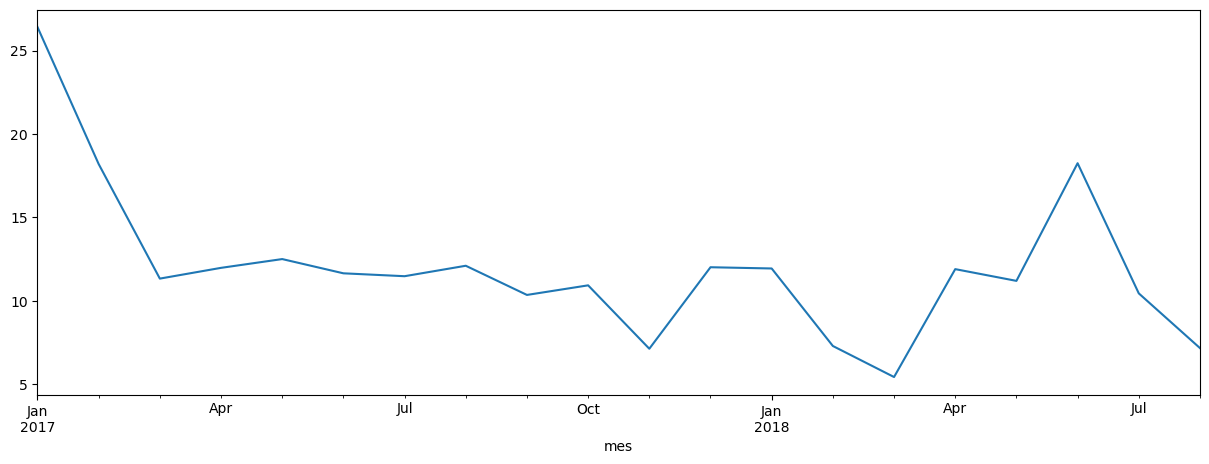

In [19]:
# Verificando o atraso por mês
pedidos.groupby('mes')['atraso'].mean().plot(figsize=(15,5));

In [22]:
pedidos.groupby('mes')['atraso'].count()

mes
2017-01     750
2017-02    1653
2017-03    2546
2017-04    2303
2017-05    3545
2017-06    3135
2017-07    3872
2017-08    4193
2017-09    4150
2017-10    4478
2017-11    7288
2017-12    5513
2018-01    7069
2018-02    6556
2018-03    7003
2018-04    6798
2018-05    6749
2018-06    6096
2018-07    6156
2018-08    6351
Freq: M, Name: atraso, dtype: int64

In [21]:
media = pedidos.groupby('mes')['atraso'].mean()
minimo = pedidos.groupby('mes')['atraso'].min()
maximo = pedidos.groupby('mes')['atraso'].max()

## Gráfico de Min, Max e Média 

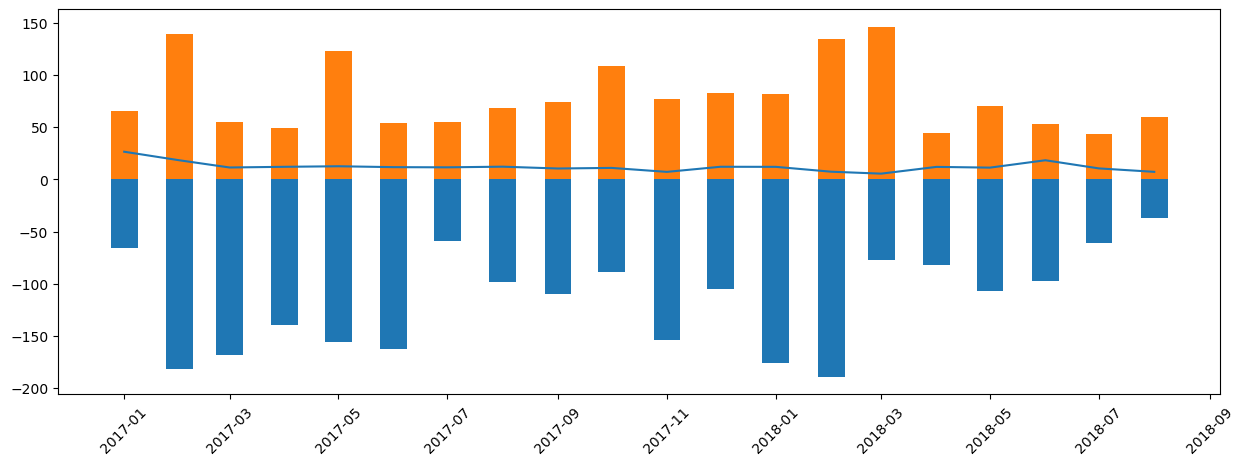

In [23]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(media.index.to_timestamp(), media.values)
ax.bar(minimo.index.to_timestamp(), minimo.values,width=15)
ax.bar(maximo.index.to_timestamp(), maximo.values,width=15)

plt.xticks(rotation=45)

plt.show()

## E se analisarmos a quantidade de pedidos com atraso?

In [24]:
pedidos['flag_atraso'] = pedidos.atraso.apply(lambda x: 1 if x < 0 else 0)

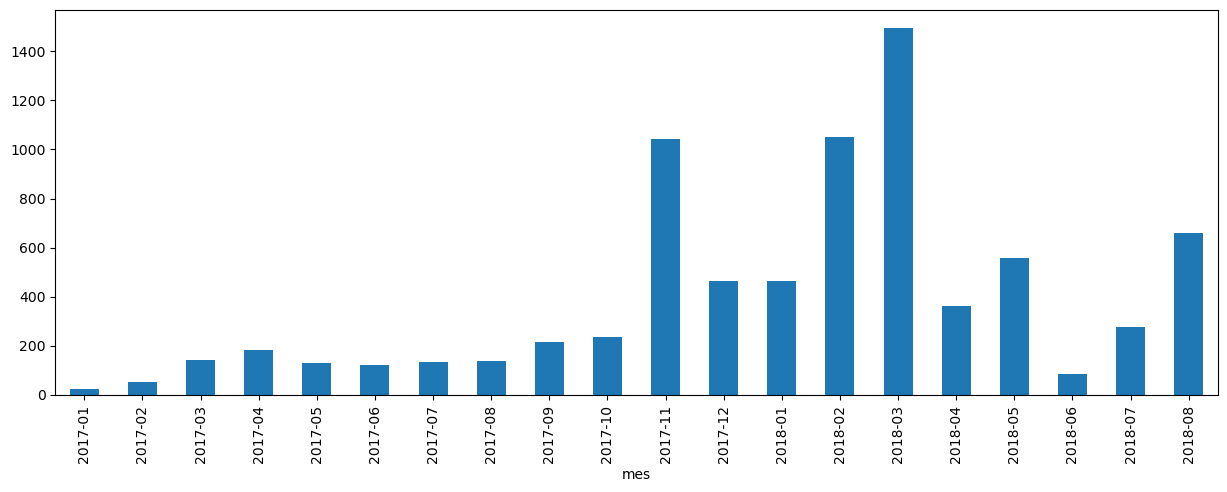

In [25]:
pedidos.groupby('mes')['flag_atraso'].sum().plot.bar(figsize=(15, 5));

In [26]:
pedidos_atrasados = pedidos.groupby('mes')['flag_atraso'].sum()
contagem_pedidos = pedidos.groupby('mes')['flag_atraso'].count()
percentual = round((pedidos_atrasados/contagem_pedidos)*100,1)

## Total de Pedidos e Pedidos atrasados 

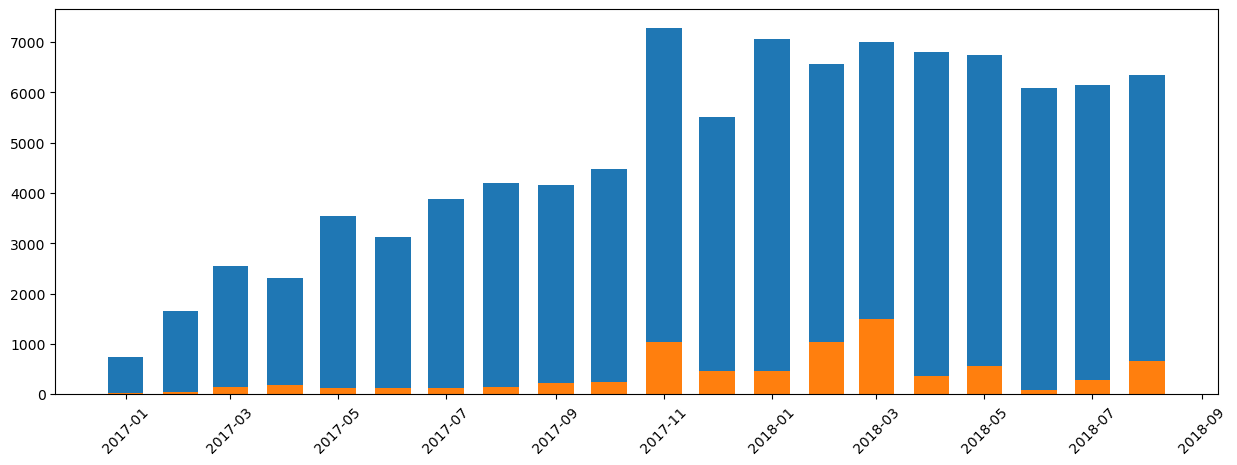

In [27]:
fig, ax = plt.subplots(figsize=(15,5))

ax.bar(contagem_pedidos.index.to_timestamp(), contagem_pedidos.values, width=20)
ax.bar(pedidos_atrasados.index.to_timestamp(), pedidos_atrasados.values, width=20)


plt.xticks(rotation=45)

plt.show()

### Ajustando o Gráfico para melhor visualização

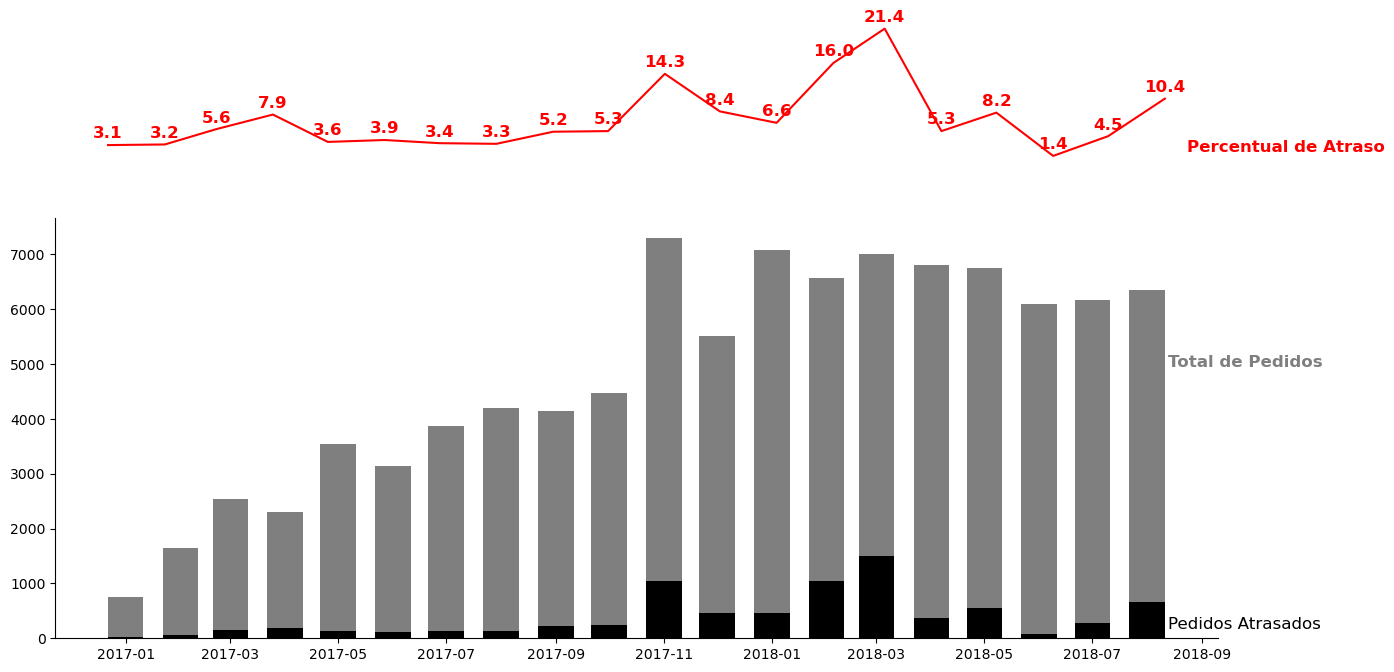

In [179]:
# Visualizando graficamefig, ax = plt.subplots(figsize=(15,5))
fig, ax = plt.subplots(nrows=2, figsize=(15,8), gridspec_kw={'height_ratios': [1,3]})


ax[1].bar(contagem_pedidos.index.to_timestamp(), contagem_pedidos.values, width=20, color='tab:gray')
ax[1].bar(pedidos_atrasados.index.to_timestamp(), pedidos_atrasados.values, width=20, color="black")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].annotate("Total de Pedidos",(contagem_pedidos.index.to_timestamp()[-1],contagem_pedidos.values[1]),
               ha="left",xytext=(15,130),textcoords="offset points", c="tab:gray", fontsize=12, weight='bold')   
    
ax[1].annotate("Pedidos Atrasados",(pedidos_atrasados.index.to_timestamp()[-1],pedidos_atrasados.values[1]),
               ha="left",xytext=(15,5),textcoords="offset points", c="black", fontsize=12)   


ax[0].plot(percentual.index.to_timestamp(), percentual.values, c="r")

for i in range(0, len(percentual)):
    ax[0].annotate(percentual.values[i],(percentual.index.to_timestamp()[i],percentual.values[i]),
               ha="center",xytext=(0,5),textcoords="offset points", c="r", fontsize=12, weight='bold')
ax[0].annotate("Percentual de Atraso",(percentual.index.to_timestamp()[-1],percentual.values[1]),
               ha="left",xytext=(16,-5),textcoords="offset points", c="r", fontsize=12, weight='bold')   
    
    
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

plt.savefig("Percentual Atraso", bbox_inches='tight', transparent=True)

In [185]:
(pedidos_atrasados.sum()/contagem_pedidos.sum()) *100

8.1316785164858

96204

In [29]:
avaliacoes = executa_sql('SELECT  * FROM order_reviews')

(99224, 8)


,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [30]:
avaliacoes[avaliacoes.review_score.isnull()]

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [31]:
round(avaliacoes.review_score.value_counts().sort_index()/avaliacoes.shape[0]*100,1)

review_score
1    11.5
2     3.2
3     8.2
4    19.3
5    57.8
Name: count, dtype: float64

In [32]:
avaliacao_ordem = executa_sql('SELECT * FROM orders o \
                                LEFT JOIN order_reviews ore \
                                ON o.order_id = ore.order_id')

(99992, 17)


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,32790.0,a54f0611adc9ed256b57ede6b6eb5114,e481f51cbdc54678b7cc49136f2d6af7,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,29158.0,8d5266042046a06655c8db133d120ba5,53cdb2fc8bc7dce0b6741e2150273451,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,4323.0,e73b67b67587f7644d5bd1a52deb1b01,47770eb9100c2d0c44946d9cf07ec65d,5.0,None,None,2018-08-18 00:00:00,2018-08-22 19:07:58
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,77520.0,359d03e676b3c069f62cadba8dd3f6e8,949d5b44dbf5de918fe9c16f97b45f8a,5.0,None,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,54136.0,e50934924e227544ba8246aeb3770dd4,ad21c59c0840e6cb83a9ceb5573f8159,5.0,None,None,2018-02-17 00:00:00,2018-02-18 13:02:51


In [33]:
avaliacao_ordem = executa_sql('SELECT o.order_id \
                              ,o.order_purchase_timestamp \
                              ,o.order_delivered_customer_date \
                              ,o.order_estimated_delivery_date \
                              ,review_score \
                              FROM orders o \
                              LEFT JOIN order_reviews ore \
                              ON o.order_id = ore.order_id')

(99992, 5)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,5.0


In [34]:
avaliacao_ordem[avaliacao_ordem.review_score.isnull()]

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
16,403b97836b0c04a622354cf531062e5f,2018-01-02 19:00:43,2018-01-20 01:38:59,2018-02-06 00:00:00,NaN
154,6942b8da583c2f9957e990d028607019,2018-01-10 11:33:07,None,2018-02-07 00:00:00,NaN
311,4906eeadde5f70b308c20c4a8f20be02,2017-12-08 04:45:26,2018-01-09 18:04:58,2018-01-03 00:00:00,NaN
382,b7a4a9ecb1cd3ef6a3e36a48e200e3be,2017-05-19 18:13:54,2017-06-08 07:53:42,2017-06-16 00:00:00,NaN
390,59b32faedc12322c672e95ec3716d614,2018-06-27 11:10:11,2018-07-06 16:37:36,2018-07-26 00:00:00,NaN
...,...,...,...,...,...
99242,0c384d67524b5b92aa2fa6c8baa9a983,2017-06-05 19:20:11,2017-06-13 14:09:21,2017-06-27 00:00:00,NaN
99327,906a6b0a96d89ee226e4977e99b80b9e,2017-08-28 15:14:21,2017-09-05 19:47:44,2017-09-18 00:00:00,NaN
99554,5333db16fe357175d39c82840dd3269d,2018-03-10 18:18:20,2018-04-03 15:32:52,2018-03-29 00:00:00,NaN
99684,2f2df159f26ddb73d55ee72372200d3e,2017-07-17 01:19:50,2017-07-26 09:44:00,2017-08-09 00:00:00,NaN


In [35]:
pedidos.shape[0] - avaliacoes.shape[0]

-3020

### Sera que alguma avaliacao apareceu mais de uma vez ?

In [36]:
avaliacao_ordem.order_id.value_counts()

order_id
8e17072ec97ce29f0e1f111e598b0c85    3
03c939fd7fd3b38f8485a0f95798f1f6    3
c88b1d1b157a9999ce368f218a407141    3
df56136b8031ecd28e200bb18e6ddb2e    3
95442deb81a5d91c97c0df96b431634a    2
                                   ..
94a1020970476388adf12c46628499be    1
b266c12d9bececa3942c1bef84f13716    1
e82e0697786dcef38c215ec9d2dc308a    1
e940e33cefca8e48b759474760c2fb41    1
66dea50a8b16d9b4dee7af250b4be1a5    1
Name: count, Length: 99441, dtype: int64

In [37]:
avaliacoes[avaliacoes.order_id == "03c939fd7fd3b38f8485a0f95798f1f6"]

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
8273,8273,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,None,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 00:00:00,2018-03-21 02:28:23
51527,51527,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,None,None,2018-03-29 00:00:00,2018-03-30 00:29:09
69438,69438,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,None,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 00:00:00,2018-03-06 19:50:32


In [41]:
avaliacao_ordem[avaliacao_ordem.order_id == "03c939fd7fd3b38f8485a0f95798f1f6"]

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
12430,03c939fd7fd3b38f8485a0f95798f1f6,2018-02-25 21:01:08,2018-03-19 21:48:52,2018-04-02 00:00:00,3.0
12431,03c939fd7fd3b38f8485a0f95798f1f6,2018-02-25 21:01:08,2018-03-19 21:48:52,2018-04-02 00:00:00,3.0
12432,03c939fd7fd3b38f8485a0f95798f1f6,2018-02-25 21:01:08,2018-03-19 21:48:52,2018-04-02 00:00:00,4.0


#### Tratando registros com mais de 1 linha

In [42]:
media = avaliacao_ordem.groupby('order_id')["review_score"].mean().reset_index()
media.columns = ["order_id", 'media_nota']
media.head()

,order_id,media_nota
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0


In [43]:
media.media_nota.value_counts().sort_index()

media_nota
1.000000    11316
1.500000        8
2.000000     3125
2.500000       34
3.000000     8136
3.333333        1
3.500000       25
4.000000    19018
4.333333        1
4.500000       54
5.000000    56955
Name: count, dtype: int64

In [44]:
maximo = avaliacao_ordem.groupby('order_id')["review_score"].max().reset_index()
maximo.columns = ["order_id", 'nota_maxima']
maximo

,order_id,nota_maxima
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0
...,...,...
99436,fffc94f6ce00a00581880bf54a75a037,5.0
99437,fffcd46ef2263f404302a634eb57f7eb,5.0
99438,fffce4705a9662cd70adb13d4a31832d,5.0
99439,fffe18544ffabc95dfada21779c9644f,5.0


In [45]:
maximo.nota_maxima.value_counts().sort_index()

nota_maxima
1.0    11316
2.0     3121
3.0     8116
4.0    19044
5.0    57076
Name: count, dtype: int64

### Utilizando SQL para trazer as notas medias e maximas de Review_Score

In [46]:
avaliacao_ordem = executa_sql('SELECT o.order_id \
                              ,o.order_purchase_timestamp \
                              ,o.order_delivered_customer_date \
                              ,o.order_estimated_delivery_date \
                              ,ROUND (AVG(review_score),1) as media_nota\
                              ,ROUND (MAX(review_score),1) as nota_maxima\
                              FROM orders o \
                              LEFT JOIN order_reviews ore \
                              ON o.order_id = ore.order_id \
                              WHERE ore.review_score IS NOT NULL \
                             GROUP BY \
                               o.order_id \
                              ,o.order_purchase_timestamp \
                              ,o.order_delivered_customer_date \
                              ,o.order_estimated_delivery_date')

(98673, 6)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,media_nota,nota_maxima
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,5.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15 00:00:00,4.0,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05 00:00:00,5.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20 00:00:00,4.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17 00:00:00,5.0,5.0


In [47]:
avaliacao_ordem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       98673 non-null  object 
 1   order_purchase_timestamp       98673 non-null  object 
 2   order_delivered_customer_date  95830 non-null  object 
 3   order_estimated_delivery_date  98673 non-null  object 
 4   media_nota                     98673 non-null  float64
 5   nota_maxima                    98673 non-null  float64
dtypes: float64(2), object(4)
memory usage: 4.5+ MB


In [48]:
colunas_datas = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in colunas_datas:
    avaliacao_ordem[i] = pd.to_datetime(avaliacao_ordem[i], format='%Y-%m-%d %H:%M:%S')

In [49]:
avaliacao_ordem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98673 non-null  object        
 1   order_purchase_timestamp       98673 non-null  datetime64[ns]
 2   order_delivered_customer_date  95830 non-null  datetime64[ns]
 3   order_estimated_delivery_date  98673 non-null  datetime64[ns]
 4   media_nota                     98673 non-null  float64       
 5   nota_maxima                    98673 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 4.5+ MB


In [50]:
avaliacao_ordem.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,media_nota,nota_maxima
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,5.0,5.0


In [51]:
avaliacao_ordem.groupby(['media_nota','nota_maxima'])['order_id'].count()

media_nota  nota_maxima
1.0         1.0            11316
1.5         2.0                8
2.0         2.0             3113
            3.0               12
2.5         3.0               10
            4.0               24
3.0         3.0             8094
            4.0                9
            5.0               33
3.3         4.0                1
3.5         4.0               17
            5.0                8
4.0         4.0            18993
            5.0               25
4.3         5.0                1
4.5         5.0               54
5.0         5.0            56955
Name: order_id, dtype: int64

In [53]:
avaliacao_ordem[avaliacao_ordem.media_nota != avaliacao_ordem.nota_maxima].groupby(['media_nota','nota_maxima'])['order_id'].count()

media_nota  nota_maxima
1.5         2.0             8
2.0         3.0            12
2.5         3.0            10
            4.0            24
3.0         4.0             9
            5.0            33
3.3         4.0             1
3.5         4.0            17
            5.0             8
4.0         5.0            25
4.3         5.0             1
4.5         5.0            54
Name: order_id, dtype: int64

In [55]:
avaliacao_ordem[avaliacao_ordem.media_nota != avaliacao_ordem.nota_maxima].shape[0]/avaliacao_ordem.shape[0]

0.002047165891378594

In [56]:
avaliacao_ordem["nota"] = avaliacao_ordem.nota_maxima

In [57]:
avaliacao_ordem = avaliacao_ordem.drop(['media_nota', 'nota_maxima'], axis=1)

In [59]:
avaliacao_ordem.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,5.0


In [65]:
avaliacao_ordem['atraso'] = pd.to_timedelta(avaliacao_ordem.order_estimated_delivery_date.dt.date - avaliacao_ordem.order_delivered_customer_date.dt.date).dt.days

In [66]:
avaliacao_ordem['flag_atraso'] = avaliacao_ordem.atraso.apply(lambda x: 1 if x < 0 else 0)

In [68]:
avaliacao_ordem[avaliacao_ordem.atraso < 0].head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso
20,000e906b789b55f64edcb1f84030f90d,2017-11-21 18:54:23,2017-12-09 17:27:23,2017-12-07,3.0,-2.0,1
36,0017afd5076e074a48f1f1a4c7bac9c5,2017-04-06 22:16:10,2017-05-23 08:32:07,2017-05-19,1.0,-4.0,1
42,001c85b5f68d2be0cb0797afc9e8ce9a,2017-11-24 19:19:18,2017-12-22 18:37:40,2017-12-14,2.0,-8.0,1
43,001d8f0e34a38c37f7dba2a37d4eba8b,2017-05-14 17:19:44,2017-05-26 13:14:50,2017-05-24,1.0,-2.0,1
74,0030d783f979fbc5981e75613b057344,2017-11-24 20:03:02,2018-01-06 00:25:43,2017-12-15,1.0,-22.0,1


#### Verificando a correlacao entre atraso e nota

In [69]:
avaliacao_ordem.groupby('flag_atraso')['nota'].mean()

flag_atraso
0    4.214376
1    2.274052
Name: nota, dtype: float64

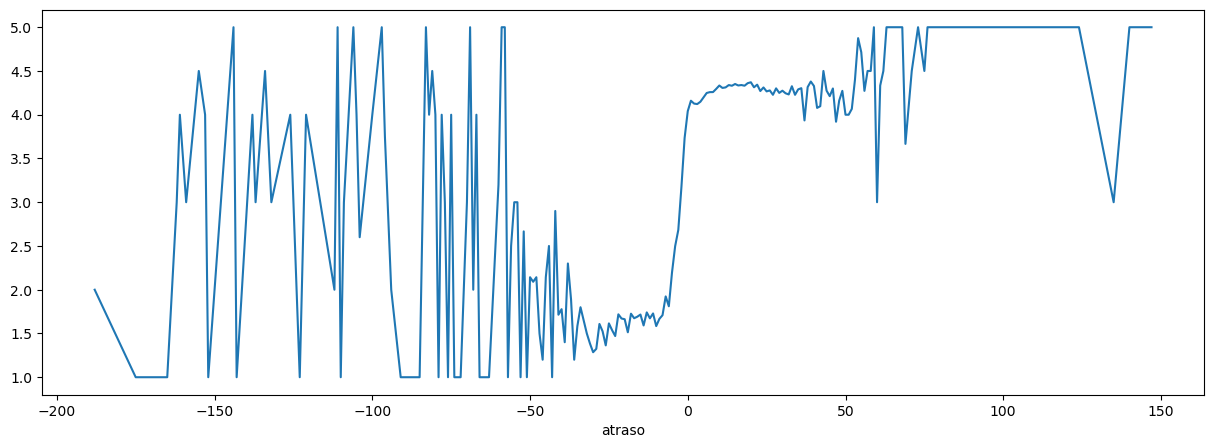

In [72]:
avaliacao_ordem.groupby('atraso')['nota'].mean().plot(figsize=(15,5));

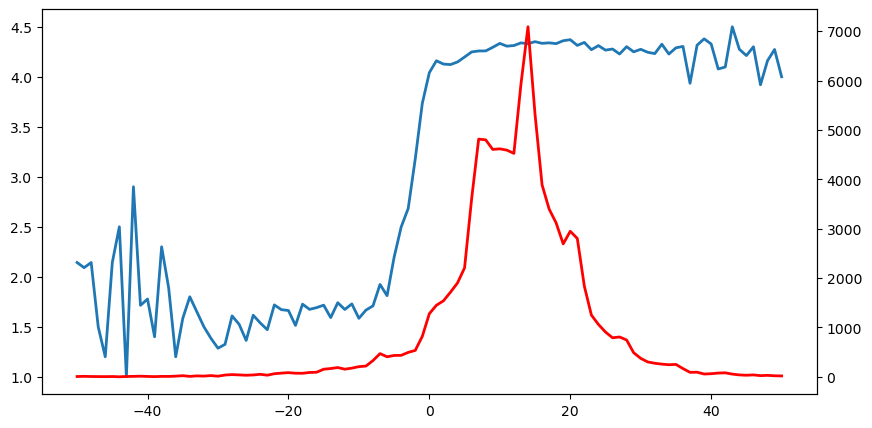

In [87]:
fig, ax = plt.subplots(figsize=(10,5))

base2 = avaliacao_ordem[(avaliacao_ordem.atraso >= -50) & (avaliacao_ordem.atraso <= 50)]

media_notas = base2.groupby('atraso')['nota'].mean()
qtd_avaliacao = base2.groupby('atraso')['nota'].count()

ax2 = ax.twinx()

ax.plot(media_notas.index, media_notas.values, linewidth=2.0)
ax2.plot(qtd_avaliacao.index, qtd_avaliacao.values, linewidth=2.0, c='r')

plt.show()

### Denfinindo uma função para facilitar o código

In [92]:
def agrupar_atraso(atraso):
    if atraso <= -50:
        return "01. Abaixo de 50 dias"
    elif atraso <= -40:
        return "02. Entre 50 e 40 dias"
    elif atraso  <= -30:
        return "03. Entre 40 e 30 dias"
    elif atraso <= -20:
        return "04. Entre 30 e 20 dias"
    elif atraso <= -10:
        return "05. Entre 20 e 10 dias de atraso"
    else:
        return "Nada aconteceu"

# # Gráfico de média por notas

In [97]:
avaliacao_ordem['grupo_atraso'] = avaliacao_ordem.atraso.apply(agrupar_atraso)

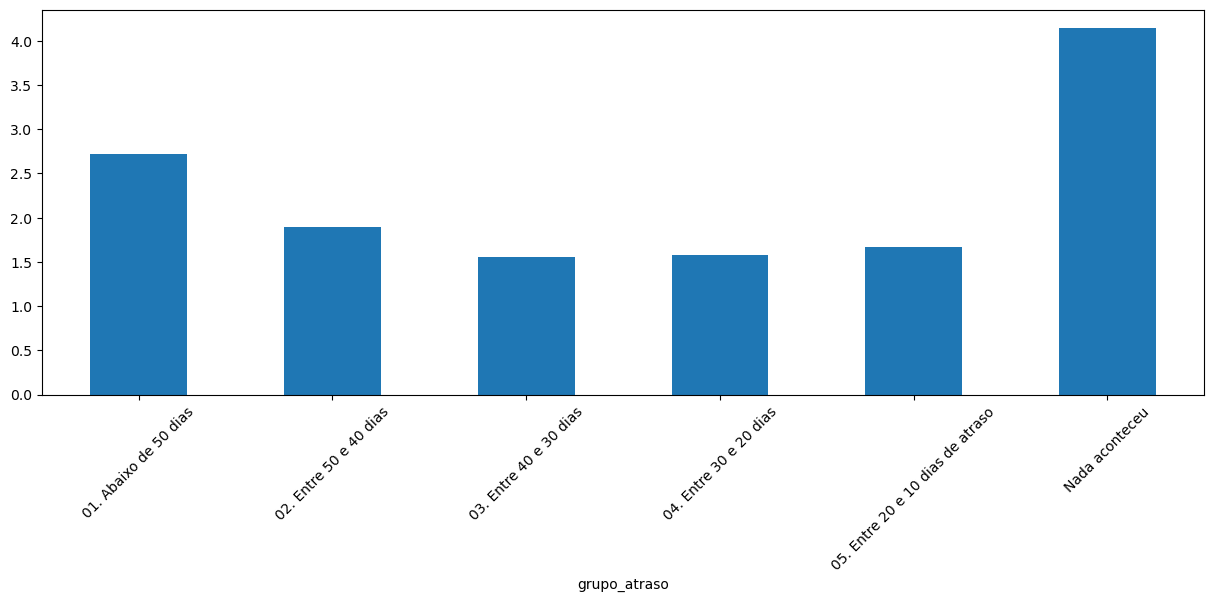

In [100]:
avaliacao_ordem.groupby('grupo_atraso')['nota'].mean().plot.bar(figsize=(15,5));
plt.xticks(rotation=45);

In [102]:
def agrupar_atraso(atraso):
    if atraso < -20:
        return '01. Mais de 20 dias de atraso'
    elif atraso < -15:
        return '02. Entre 15 e 20 dias de atraso'
    elif atraso < -10:
        return '03. Entre 10 e 15 dias de atraso'
    elif atraso < -8:
        return '04. Entre 8 e 10 dias de atraso'
    elif atraso < -6:
        return '05. Entre 6 e 8 dias de atraso'
    elif atraso < -4:
        return '06. Entre 4 e 6 dias de atraso'
    elif atraso < -2:
        return '07. Entre 2 e 4 dias de atraso'
    elif atraso < 0:
        return '08. Entre 1 e 2 dias de atraso'
    elif atraso == 0:
        return '09. Entregue na data'
    elif atraso <= 2:
        return '10. Entre 0 e 2 dias antes do prazo'
    elif atraso <= 4:
        return '11. Entre 2 e 4 dias antes do prazo'
    elif atraso <= 6:
        return '12. Entre 4 e 6 dias antes do prazo' 
    elif atraso <= 8:
        return '13. Entre 6 e 8 dias antes do prazo' 
    elif atraso <= 10:
        return '14. Entre 8 e 10 dias antes do prazo' 
    elif atraso <= 15:
        return '15. Entre 10 e 15 dias antes do prazo' 
    elif atraso <= 20:
        return '16. Entre 15 e 20 dias antes do prazo' 
    elif atraso <= 30:
        return '17. Entre 20 e 30 dias antes do prazo' 
    elif atraso <= 40:
        return '18. Entre 30 e 40 dias antes do prazo' 
    elif atraso > 40:
        return '19. Mais de 40 dias antes do prazo' 
    else:
        return '20. Verificar'

In [103]:
avaliacao_ordem['grupo_atraso'] = avaliacao_ordem.atraso.apply(agrupar_atraso)

In [104]:
avaliacao_ordem[avaliacao_ordem.grupo_atraso == '20. Verificar']

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso,grupo_atraso
24,0010dedd556712d7bb69a19cb7bbd37a,2017-10-21 19:32:06,NaT,2017-11-03,1.0,NaN,0,20. Verificar
72,002f19a65a2ddd70a090297872e6d64e,2018-03-21 13:05:30,NaT,2018-04-16,3.0,NaN,0,20. Verificar
76,00310b0c75bb13015ec4d82d341865a4,2018-08-15 14:29:08,NaT,2018-08-29,1.0,NaN,0,20. Verificar
227,00a500bc03bc4ec968e574c2553bed4b,2017-11-23 10:53:01,NaT,2018-01-08,2.0,NaN,0,20. Verificar
233,00a99c50fdff7e36262caba33821875a,2018-08-17 16:25:04,NaT,2018-09-18,5.0,NaN,0,20. Verificar
...,...,...,...,...,...,...,...,...
98324,ff0768e3356919b32e3d7f30baecfcfb,2018-04-04 22:58:39,NaT,2018-04-23,1.0,NaN,0,20. Verificar
98396,ff358345576214cc9e08488188973c84,2018-03-03 17:05:12,NaT,2018-04-02,1.0,NaN,0,20. Verificar
98437,ff536d93ae4214b4d51c2894ccfc569f,2017-12-21 09:01:00,NaT,2018-01-10,3.0,NaN,0,20. Verificar
98471,ff7140ba310a4717112d39c0cd0b4062,2017-05-19 18:11:21,NaT,2017-06-26,1.0,NaN,0,20. Verificar


In [105]:
avaliacao_ordem = avaliacao_ordem[avaliacao_ordem.grupo_atraso != '20. Verificar']

## Analisando a média das notas por faixa de atraso

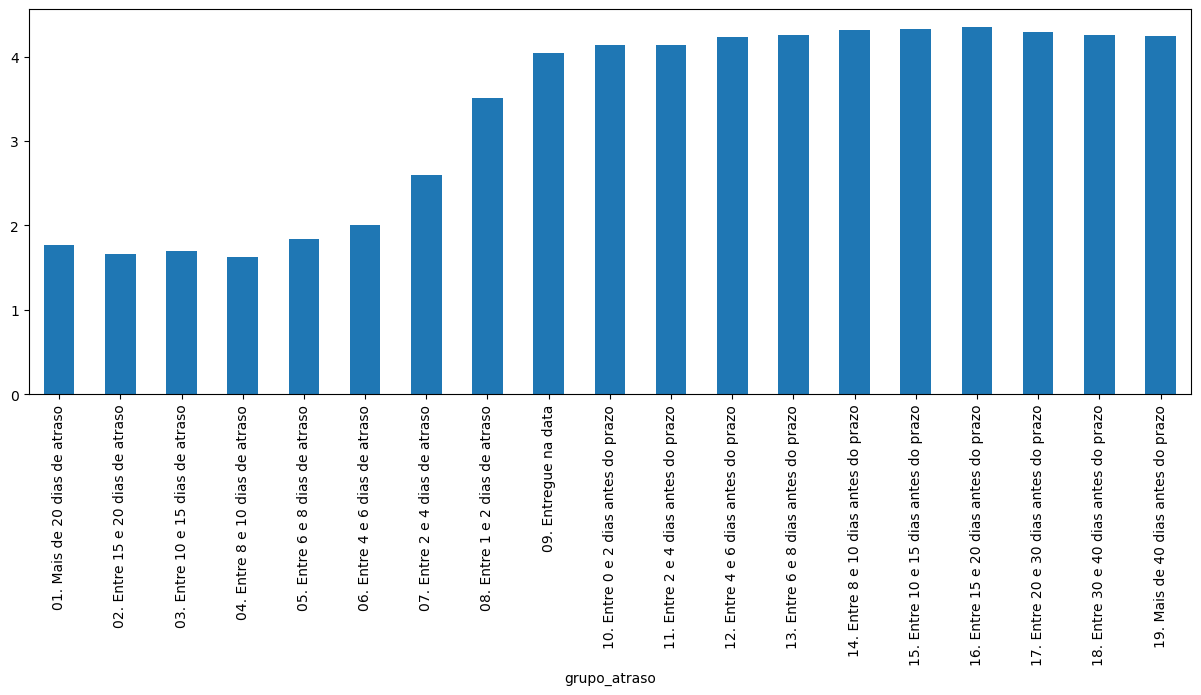

In [108]:
avaliacao_ordem.groupby('grupo_atraso')['nota'].mean().plot.bar(figsize=(15,5));


In [109]:
base_nova = avaliacao_ordem[(avaliacao_ordem.atraso >= -10) & (avaliacao_ordem.atraso <= 10)]

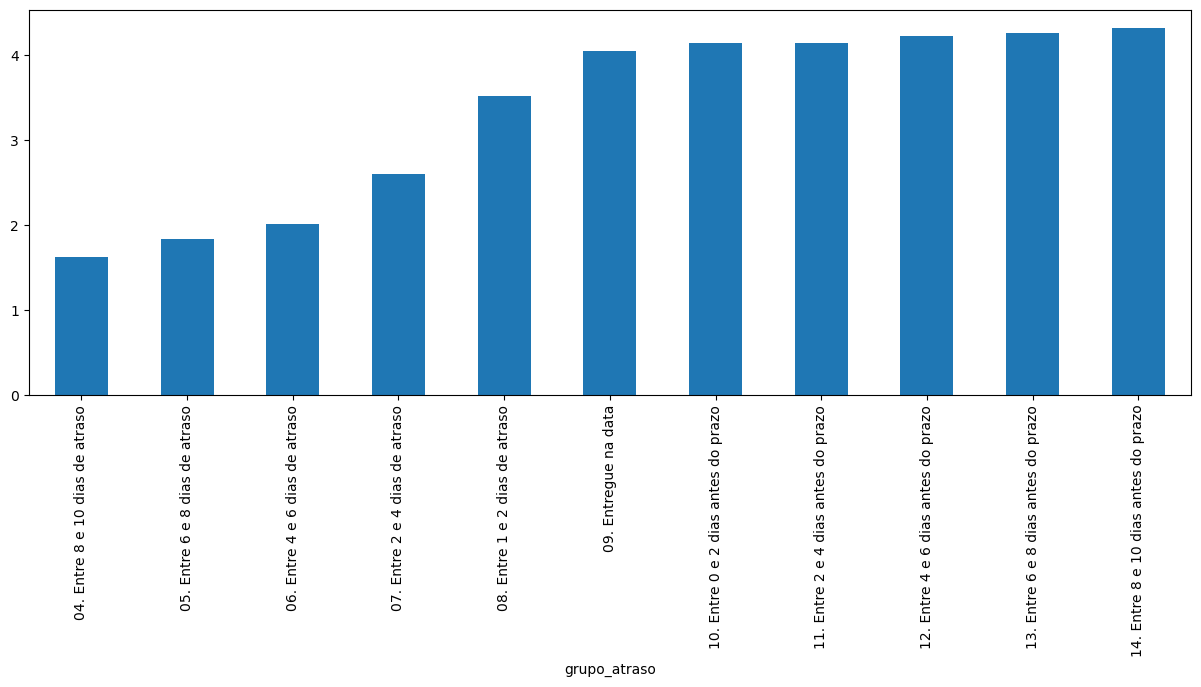

In [111]:
base_nova.groupby('grupo_atraso')['nota'].mean().plot.bar(figsize=(15,5));

In [113]:
valores_grafico = base_nova.groupby('grupo_atraso')['nota'].mean()

# Formatando e ajustando a para melhorar a *visualização*


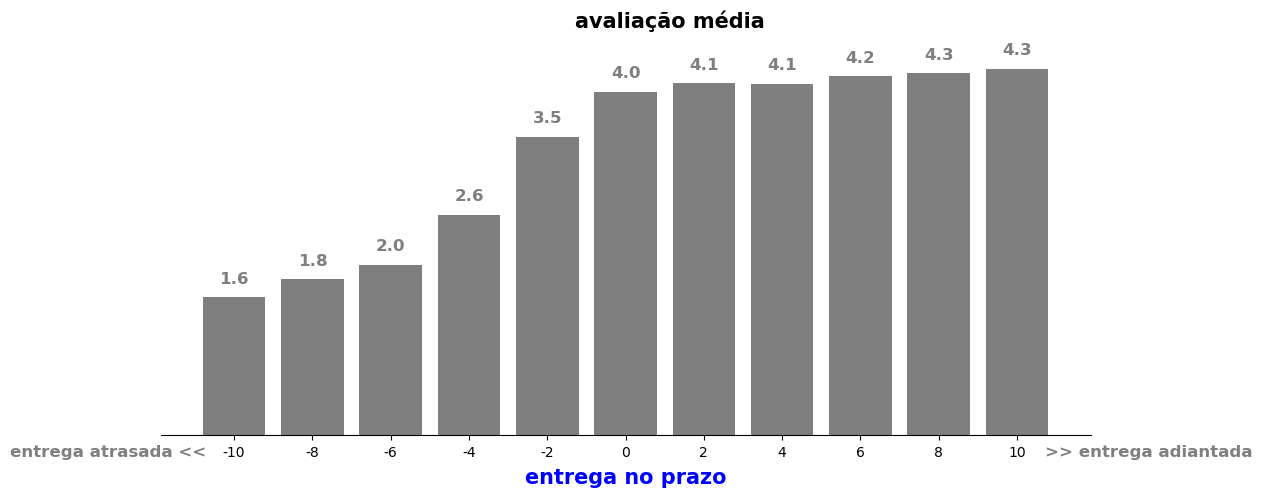

In [186]:
fig, ax = plt.subplots(figsize=(12,5))

x = np.arange(0,len(valores_grafico))

ax.bar(x,valores_grafico.values,color='tab:gray')

for i in range(0,len(valores_grafico)):
    ax.annotate(round(valores_grafico.values[i],1),(x[i],valores_grafico.values[i]),ha="center",xytext=(0,10),
               textcoords="offset points",c='tab:gray',fontsize=12,fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([-10,-8,-6,-4,-2,0,2,4,6,8,10])
ax.yaxis.set_visible(False)    
    
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('avaliação média',(x[-1],valores_grafico.values[-1]),ha="center",xytext=(-250,30),
               textcoords="offset points",c='Black',fontsize=15,fontweight='bold')
ax.annotate('entrega atrasada <<',(x[0],0),ha="right",xytext=(-20,-15),
               textcoords="offset points",c='tab:gray',fontsize=12,fontweight='bold')
ax.annotate('>> entrega adiantada',(x[-1],0),ha="left",xytext=(+20,-15),
               textcoords="offset points",c='tab:gray',fontsize=12,fontweight='bold')
ax.annotate('entrega no prazo',(x[5],0),ha="center",xytext=(0,-35),
               textcoords="offset points",c='blue',fontsize=15,fontweight='bold')

plt.savefig("Avaliacao", bbox_inches='tight', transparent=True)

In [139]:
base_nova.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso,grupo_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,9.0,0,14. Entre 8 e 10 dias antes do prazo
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,3.0,0,11. Entre 2 e 4 dias antes do prazo
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,6.0,0,12. Entre 4 e 6 dias antes do prazo
8,0005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,1.0,0.0,0,09. Entregue na data
11,00063b381e2406b52ad429470734ebd5,2018-07-27 17:21:27,2018-08-07 13:56:52,2018-08-07,5.0,0.0,0,09. Entregue na data


In [141]:
avaliacao_ordem.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso,grupo_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,9.0,0,14. Entre 8 e 10 dias antes do prazo
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,3.0,0,11. Entre 2 e 4 dias antes do prazo
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,14.0,0,15. Entre 10 e 15 dias antes do prazo
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,6.0,0,12. Entre 4 e 6 dias antes do prazo
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,5.0,16.0,0,16. Entre 15 e 20 dias antes do prazo


In [143]:
 ids = base_nova.loc[base_nova.atraso <= -5, "order_id"]

In [146]:
avaliacoes[avaliacoes.order_id.isin(ids)]

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
32,32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,None,Sempre compro pela Internet e a entrega ocorre...,2018-04-08 00:00:00,2018-04-09 12:22:39
39,39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,None,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03
45,45,3dc0777d97733a1d066f5b781e91577f,44a9994228432b835c3a4e720b6a41ab,4,None,None,2018-03-29 00:00:00,2018-03-31 00:13:07
106,106,d23ac17822a812782cf7f848b2a8b38b,705402bc1d956067338873d414158d09,1,None,None,2018-04-22 00:00:00,2018-04-26 10:25:11
168,168,d7ea05bb4f9c77d606fd90b1a27e317d,bb5b0d8f3e9c964760c674f2aa2ae0cf,1,None,Comprei o produto dia 25 de fevereiro e hoje d...,2018-03-29 00:00:00,2018-03-29 23:13:58
...,...,...,...,...,...,...,...,...
99091,99091,fade356e7332606aa22776d8d553cdce,837b75362f8a7c08c85182dfd16cb72d,1,None,Ainda nao recevi o produto.,2018-08-12 00:00:00,2018-08-12 13:51:31
99094,99094,9bab7509047d0b236205e330172b384d,e78cde66f03731202b0f5e082b0b0cff,1,None,Gostaria de saber porque meu produto ainda não...,2018-03-29 00:00:00,2018-03-29 22:21:55
99098,99098,d2aabe46dcbed6312ac19c0d5bc581bf,cdbe57b33f10dd54db2421744ab4a045,5,None,muito bom! recomendo!,2017-09-01 00:00:00,2017-09-01 18:27:53
99144,99144,e5a991ae8286f513e512f0f9fd188f9b,fadb25c91522130892be8a5ddb3e139f,1,None,None,2018-04-14 00:00:00,2018-04-16 18:37:40


In [148]:
avaliacoes.loc[avaliacoes.order_id.isin(ids),'review_comment_message']

32       Sempre compro pela Internet e a entrega ocorre...
39                            Nada de chegar o meu pedido.
45                                                    None
106                                                   None
168      Comprei o produto dia 25 de fevereiro e hoje d...
                               ...                        
99091                          Ainda nao recevi o produto.
99094    Gostaria de saber porque meu produto ainda não...
99098                                muito bom! recomendo!
99144                                                 None
99174                                                 None
Name: review_comment_message, Length: 2078, dtype: object

# Criando Nuvem de Palavras
    - utilizando WordCloud

## Preparando texto
    - fezendo um loop

### Ajustando a Imagem

    - Ajustando o Layout

In [150]:
for i in avaliacoes.loc[avaliacoes.order_id.isin(ids),'review_comment_message']:
    print(i)


Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.
Nada de chegar o meu pedido.
None
None
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.
None
Não posso! Estou aguardando a chegada do produto que comprei!Logo que isso aconteça, terei minha opinião formada!
Comprei dois produtos e recebi somente um. Mandei dois emails para a loja e não tive nenhum retorno. Estou insatisfeita.
Até agora nao recebi.Comprei este aparelho por questao de saude,portanto nao recomendo esta loja.
comprei um produto para ser entregue por essa loja
e ainda não recebi
pois assim já se passou a data de entrega
None
Até agora não recebi nada, a colcha estava prevista para anteontem(18/12) e até agora nada
None
None
None
Até o momento eu n recebir o produto
N

In [157]:
texto = ''
for i in avaliacoes.loc[avaliacoes.order_id.isin(ids),'review_comment_message']:
    if i:
        texto += i
        texto += ''

In [158]:
texto

'Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.Nada de chegar o meu pedido.Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.Não posso! Estou aguardando a chegada do produto que comprei!Logo que isso aconteça, terei minha opinião formada!Comprei dois produtos e recebi somente um. Mandei dois emails para a loja e não tive nenhum retorno. Estou insatisfeita.Até agora nao recebi.Comprei este aparelho por questao de saude,portanto nao recomendo esta loja.comprei um produto para ser entregue por essa loja\r\ne ainda não recebi\r\npois assim já se passou a data de entregaAté agora não recebi nada, a colcha estava prevista para anteontem(18/12) e até agora nadaAté o momento eu n recebir o produtoNão recebi o produto.e agora?Preciso d

In [152]:
from wordcloud import WordCloud

In [163]:
wordcloud = WordCloud(stopwords=['o', 'dia', 'que','e']).generate(texto)

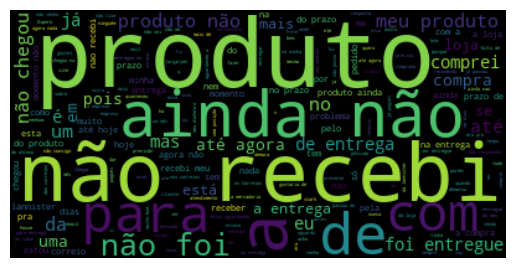

In [164]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [165]:
texto = ''
for i in avaliacoes.loc[avaliacoes.order_id.isin(ids),'review_comment_message']:
    if i:
        i = i.replace(' ','')
        texto += i
        texto += ''

In [176]:
wordcloud = WordCloud(stopwords=['Bomdia', 'mail', 'porém'], colormap='plasma').generate(texto)

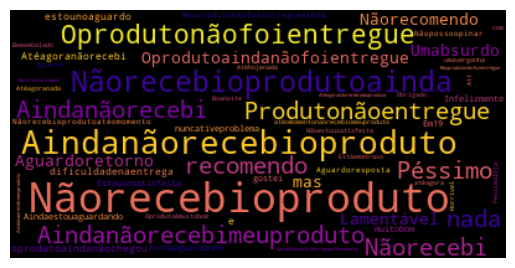

In [187]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("Nuvem de Palavras", bbox_inches='tight', transparent=True)